# Introduction to Spiking Neural Networks
A Machine Learning & Data Analytics Lab (MLDA@EEE) Workshop\
Author: Leow Cong Sheng & Ng Ho Chi\
28 Feb 2022

### Section I: Preparation
Dependencies required are being imported, and data is being prepared.

Before we do anything, we will prepare the datasets. In order of cells, we are going to:
1. Import necessary libraries
2. Connect to GPU if available. Remember to connect to GPU if possible!
3. Define some variables (batch size and path to dataset)
4. Create some transformations for the images, as well as apply the transformations on the MNIST dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils, nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [ ]:
# User-specified batch size and data for MNIST
batch_size = 128
data_path='/data/mnist'

In [ ]:
# Define transformations
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Label for sample data: 5
Size of data: torch.Size([1, 28, 28])


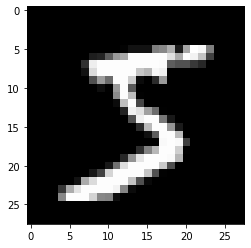

In [ ]:
sample_idx = 0
sample_data, sample_label =  mnist_train[sample_idx]
plt.imshow(sample_data[0], cmap="gray")
print(f"Label for sample data: {sample_label}")
print(f"Size of data: {sample_data.size()}")

## Section II: Traditional Neural Network
A brief look into how an example of conventional neural network is used for the MNIST dataset classification.

For people more familiar with tensorflow, `nn.Linear` is basically kind of the same as the dense layer there.

Convolutional layers are initialized like this: `nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding)`

To refresh, in `__init__`, we first create layers without initializing them. Then, in `forward`, we want propagate the function value `x` through all of the layers we've created.

Note that the number of input channels of one layer is basically the number of output channels of the previous layer.

### Definition of Network

In [ ]:
class CNN_model(nn.Module):
    def __init__(self, input_channel=1):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(input_channel, 16, 5, 1, 2) ### Initialize Convolutional Layer here ###
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2) ### Initialize second Convolutional Layer here ###
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

model = CNN_model().to(device)
print(model)

CNN_model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)


### Training and Testing

Here, we initialize the loss function that will be used when we are going to work on our train and test data, an optimizer, as well as the epoch which will be used later.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epoch_num = 2

Here, we create the functions for the train batch and test batch. 

For the train batch, we are focusing on trying to improve the model.

For the test batch, we are focusing on the evaluation of the model that was trained by the train batch.

In [ ]:
def train_batch(model_train, training_dl, epochs, print_step = 100):
    model_train.train()
    size = len(training_dl.dataset)
    for epoch in range(epochs):
        running_lost, correct = 0.0, 0
        for i, (data, target)in enumerate(training_dl):
            inputs, labels = data.to(device), target.to(device)
            optimizer.zero_grad() # Clear the gradient
            outputs = model_train(inputs) # Try the model on the train inputs
            loss = loss_fn(outputs, labels) # Calculate the loss function value based on the outputs from model and the actual values
            loss.backward() # Backward propagation
            optimizer.step()
            correct += (outputs.argmax(1) == labels).float().sum()
            if i % print_step == 0:
                loss, current = loss.item(), i * len(inputs)
                print(f'Epoch: {epoch+1} | loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
        accuracy = 100 * correct / size
        print(f"Epoch: {epoch+1} | accuracy: {accuracy}")
    print('Finished Training')

def test_batch(model_test, testing_dl):
    model_test.eval()
    size = len(testing_dl.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(testing_dl):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct = int(correct)

   # print(f'Test Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

    print(f"Total correctly classified test set images: {correct}/{size}")
    print(f"Test set accuracy: {100 * correct/size:.2f}%, avg loss: {test_loss:>8f}")

### Evaluation
Here, we execute the functions created earlier and get the accuracy.

We also plot a diagram to compare the first 10 images with the predicted results.

In [ ]:
train_batch(model, train_loader, epoch_num)

Epoch: 1 | loss: 2.299605  [    0/60000]
Epoch: 1 | loss: 0.276428  [12800/60000]
Epoch: 1 | loss: 0.112493  [25600/60000]
Epoch: 1 | loss: 0.134258  [38400/60000]
Epoch: 1 | loss: 0.061458  [51200/60000]
Epoch: 1 | accuracy: 93.3133316040039
Epoch: 2 | loss: 0.066642  [    0/60000]
Epoch: 2 | loss: 0.045145  [12800/60000]
Epoch: 2 | loss: 0.028015  [25600/60000]
Epoch: 2 | loss: 0.082727  [38400/60000]
Epoch: 2 | loss: 0.007151  [51200/60000]
Epoch: 2 | accuracy: 98.16333770751953
Finished Training


In [ ]:
test_batch(model, test_loader)

Total correctly classified test set images: 9870/10000
Test set accuracy: 98.70%, avg loss: 0.000322


In [ ]:
sample = next(iter(test_loader))
imgs, lbls = sample
imgs, lbls = imgs.to(device), lbls.to(device)
actual_number = lbls[:10].cpu().numpy()
test_output = model(imgs[:10])
y_pred = torch.max(test_output, 1)[1].cpu().data.numpy().squeeze()
print(f'Prediction number: {y_pred}')
print(f'Actual number: {actual_number}')

Prediction number: [7 6 7 9 9 0 4 5 1 5]
Actual number: [7 6 7 9 9 0 4 5 1 5]


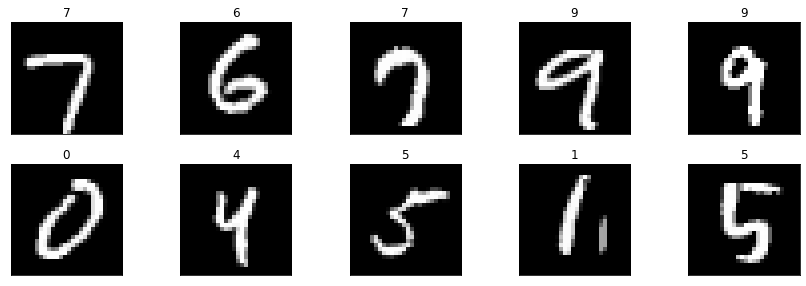

In [ ]:
fig = plt.figure(figsize=(12,6))
for i in range(10):
  plt.subplot(3,5, i+1)
  plt.tight_layout()
  plt.imshow(imgs[i][0].cpu(), cmap='gray', interpolation='none')
  plt.title(y_pred[i])
  plt.xticks([])
  plt.yticks([])

## Section III: Spiking Neural Network using snnTorch
The spiking neural network (SNN) will be used instead to draw comparison between the SNN, and the traditional neural network approach in the section above.\
While many different packages have become available in the recent years, we will be implementing a SNN using [snnTorch<sup>1</sup>](https://github.com/jeshraghian/snntorch) in this workshop. The documentation page can be accessed at https://snntorch.readthedocs.io/en/latest/. \
Participants are encouraged to explore other implementation available, with some recommendations listed in the workshop's additional resources.\
<sub><sub>\[1\]- [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu “Training Spiking Neural Networks Using Lessons From Deep Learning”. arXiv preprint arXiv:2109.12894, September 2021](https://arxiv.org/abs/2109.12894).</sub></sub>

In [ ]:
!pip install snntorch

     |████████████████████████████████| 89 kB 4.0 MB/s 


In [ ]:
import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

### Definition of Network
The surrogate gradient is solution for the non-differentiable function of the spiking neuron. By smoothing out the spiking function, a differentiable approximation can be obtained, allowing backpropagation through gradient descent to be utilised.\
In this example, the sigmoid function is used to approximate or smooth out the curve, with an argument to specify the slope \: `surrogate.fast_sigmoid(slope=25)`.\
Additionally, the beta value, and the the number of time steps for the spiking neuron can be specified. The beta value determines how fast the membrane voltage decay expotentially. While this workshop will not cover all the hyperparameters for tuning, you can visit the [LIF documentation page](https://snntorch.readthedocs.io/en/latest/snn.neurons_leaky.html) to see what other parameters can be tuned. For instance, threshold voltage for the neuron is a key parameter which can affect your overall sparsity, and accuracy of the SNN. Number of time steps determine the full time steps for the spiking action.


In [ ]:
### To be completed in the workshop ### 
beta = 0.9
spike_grad = surrogate.fast_sigmoid(slope=25)### Insert surrogate gradient function here ###
step_num = 10

In the network definition below, we will use a similar CNN architecture we used previously. To convert a typical neural network to a SNN is simple using snnTorch. By using surrogate gradient, backpropagation can be used, and the main changes involve changing the typical neurons in a neural network to be spiking neurons.\
To do so, simply add LIF activations within in between the layers using `snn.Leaky(beta=beta, spike_grad=spike_grad)` with the beta and surrogate gradient function specified previously. These neurons will then be initialized by calling the neurons' `self.lif#.init_leaky()` method in the forward pass.\
The spikes and membrane voltages are produced and stored after each spiking neurons. These will then be used to inject into the subsequent layers and finally be transformed into a output value. To do so, the spikes and membrane can be obtained using `self.lif#(cur#, mem#)`based on the previous current level and membrane voltage.

In [ ]:
### To be completed in the workshop ###
class SNN_model(nn.Module):
    def __init__(self, num_steps, input_channel=1):
        super(SNN_model, self).__init__()
        self.num_steps = num_steps
        self.conv1 = nn.Conv2d(input_channel, 16, 5, 1, 2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###
        self.fc1 = nn.Linear(32*14*14, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###

    def forward(self, x):
        batch_size_curr = x.shape[0] # Get current batch_size
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()### Initialize the LIF neuron here ###
        mem2 = self.lif2.init_leaky()### Initialize the LIF neuron here ###
        mem3 = self.lif3.init_leaky()### Initialize the LIF neuron here ###

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            cur1 = self.pool(self.conv1(x))
            spk1, mem1 = self.lif1(cur1, mem1)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###
            cur3 = self.fc1(spk2.view(batch_size_curr, -1))
            spk3, mem3 = self.lif3(cur3, mem3)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)

snn_model = SNN_model(step_num).to(device)
print(snn_model)

SNN_model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif1): Leaky()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif2): Leaky()
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
  (lif3): Leaky()
)


To optimize the SNN using backpropagation, the default optimizers, and loss functions available in PyTorch can be used. Other SNN-based optimizers and loss functions are available in snnTorch.

In [ ]:
optimizer_snn = torch.optim.Adam(snn_model.parameters(), lr=1e-2, betas=(0.9, 0.999))
loss_snn = nn.CrossEntropyLoss()

### Training and Testing

In [ ]:
epoch_num = 2

In [ ]:
*_, last_set = iter(train_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(f"Shape of data: {data.shape}, Shape of targets: {targets.shape}")

Shape of data: torch.Size([96, 1, 28, 28]), Shape of targets: torch.Size([96])


**Training**\
Similar to the training loop used previously for a traditional neural network, the SNN training loop will involve the calling of the network with the data as the argument `network(data)`. Instead of just returning one variable, this will generate a record of the spikes and the membrane voltages. \
To calculate the loss, the loss function can be called with the membrane voltage record at each time step using `loss_snn(mem_rec[step], targets)`.\
While it is possible to implement the algorithm for converting the spikes record to output and compare with the targets to obtain accuracy, snnTorch offers the function `SF.accuracy_rate(spk_rec, targets)` which allows the accuracy to be obtained.\
**Testing**\
In the testing function, we will now implement the accuracy and loss calculation instead of using the accuracy_rate. Firstly, the predicted values should be obtained by using `test_spk.sum(dim=0).max(1)` which will serves as a way to get the highest value of spike occured (corresponding to the class). Next, instead of calculating the loss at every time step such as in training, we will just calculate the loss which was obtained at the end of the time step using `loss_snn(test_mem[num_steps-1], targets)`.

In [ ]:
def train_snn(network, train_dl, num_epochs, num_steps):
    loss_hist = []
    acc_hist = []
    # training loop
    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device) # Tensor to be accelerated
            targets = targets.to(device) # Tensor to be accelerated

            network.train() # Set the mode to train
            spk_rec, mem_rec = network(data) ### Invoke network upon the data ###

            loss_val = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets) ### Calculate the loss ###
                
            # Gradient calculation + weight update
            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # print every 25 iterations
            if i % 450 == 0:
                print(f"Epoch {epoch+1}, Batch {i+1} \nTrain Loss: {loss_val.item():.2f}")

                # check accuracy on a single batch
                acc = SF.accuracy_rate(spk_rec, targets)  ### Use SF's accuracy rate to calculate accuracy ###
                acc_hist.append(acc)
                print(f"Accuracy: {acc * 100:.2f}%\n")

def test_snn(network, test_dl, num_steps):
    size, correct = 0, 0
    loss_val = 0
    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem = network(data)

            _, predicted = test_spk.sum(dim=0).max(1) ### Obtain the predicted values based on spikes ###
            size += targets.size(0)
            correct += (predicted==targets).sum().item()
            loss_val += loss_snn(test_mem[num_steps-1], targets) ### Update the loss based on the last value of the spiking membrane voltage ###
    test_loss = loss_val/size
    print(f"Total correctly classified test set images: {correct}/{size}")
    print(f"Test set accuracy: {100 * correct/size:.2f}%, avg loss: {test_loss:>8f}")


In [ ]:
train_snn(snn_model, train_loader, epoch_num, step_num)

Epoch 1, Batch 1 
Train Loss: 23.01
Accuracy: 10.94%

Epoch 1, Batch 451 
Train Loss: 0.57
Accuracy: 92.97%

Epoch 2, Batch 1 
Train Loss: 1.23
Accuracy: 91.41%

Epoch 2, Batch 451 
Train Loss: 1.42
Accuracy: 88.28%



In [ ]:
test_snn(snn_model, test_loader, step_num)

Total correctly classified test set images: 9182/10000
Test set accuracy: 91.82%, avg loss: 0.000805


# Additional stuff, feel free to delete

I thought the animation would show like the spikes but I was wrong - checked with the official documentation, looks like it's still the same.

In [ ]:
def forward_pass(snn_model, data):
  mem_rec = []
  spk_rec = []
  utils.reset(snn_model)

  for step in range(25):
    spk_out, mem_out = snn_model(data)
    spk_rec.append(spk_out)
    mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
from snntorch import utils
from snntorch import spikeplot as splt
spk_rec, mem_rec = forward_pass(snn_model, data)

In [ ]:
spk_rec.shape

torch.Size([25, 10, 96, 10])

In [ ]:
spk_rec = spk_rec.reshape((25,960,10))

The target label is: 8


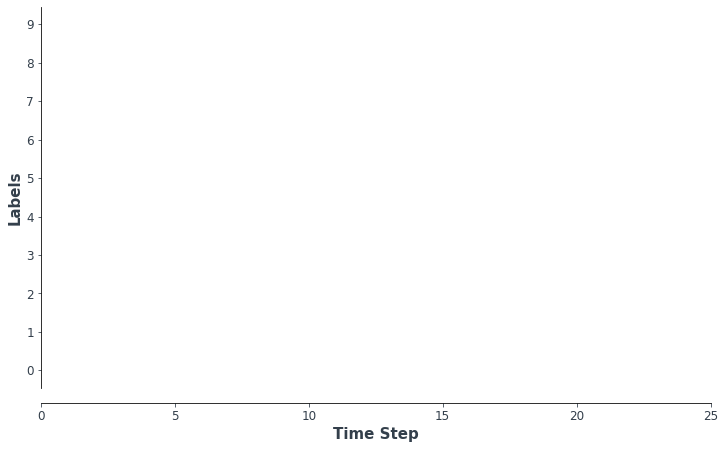

In [ ]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
